# Project Productie Proces
- Carlo Dieltjens - Raf Mesotten - Yannick Pottiez
- April 2024

## Stap 0: Importeren

#### Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import json
import sys
import random
import matplotlib.pyplot as plt 
import scipy.stats as stats
from scipy.stats import cauchy

In [2]:
# Vermijd toekomstige deprecated-fouten bij onder meer histogrammen
pd.set_option('future.no_silent_downcasting', True)

#### Functies

In [3]:
sys.path.append('../scripts')  # definieer path met scripts
from segment_calculations import create_segments
from segment_calculations import print_segment_share
from simulate_production import simulate_production
from read_files import read_json_files
from simulate import simulate
from make_a_chart import calculate_maximum
from make_a_chart import generate_point_distribution
from make_a_chart import generate_uniform_distribution
from make_a_chart import generate_normal_distribution
from make_a_chart import generate_cauchy_distribution
from make_a_chart import plot_segment_distributions
from make_a_chart import line_chart_daily_production

## Stap 1: Gegevens downloaden en organiseren

#### Definiëren van input paden
Alle input staat in de folder ```data\input```.

In [4]:
input_path = os.path.join('..', 'data', 'input')

# Definieer paden voor BRU en STO
directory_path_BRU = os.path.join(input_path, 'data_productie', 'daily_production', 'BRU')
directory_path_STO = os.path.join(input_path, 'data_productie', 'daily_production', 'STO')

## Stap 2: Git Repository initialiseren
https://github.com/craftyraf/project-productie-proces

## Stap 3: Creëer een virtuele omgeving met Anaconda
Enkel de nodige pakketten werden geinstalleerd.
In README.md staat uitgelegd hoe je je virtual environment kan opzetten.

## Stap 4: Lezen van gegevens in Python
Schrijf code om alle gegevens uit stap 1 in te lezen in Python.

#### Inlezen van 1 .json bestand

In [5]:
df = pd.read_json(os.path.join(input_path, 
                               'data_productie', 
                               'daily_production', 
                               'BRU', 
                               '20180101.json'), 
                  orient='index')
df

,0
DoW,Monday
hour,1
minute,0
date,01-01-2018 00:00:00.0000
maintenance,No
prod_loss,61
prod_loss_perc,5
production,1183


#### Inlezen van alle .json bestanden + samenvoegen in 1 dataframe voor alle locaties (met extra kolom: 'location')

In [6]:
# Lees JSON-bestanden en maak DataFrame met 'Location' kolom
BRU_df = read_json_files(directory_path_BRU, 'BRU')
STO_df = read_json_files(directory_path_STO, 'STO')

# Concateneer BRU en STO DataFrames
combined_df = pd.concat([BRU_df, STO_df], ignore_index=True)

# Toon gecombineerde DataFrame
combined_df

,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production,location
0,Monday,1,0,01-01-2018 00:00:00.0000,No,61,5,1183,BRU
1,Tuesday,1,0,01-02-2018 00:00:00.0000,No,106,9,1138,BRU
2,Wednesday,1,0,01-03-2018 00:00:00.0000,No,129,10,1115,BRU
3,Thursday,1,0,01-04-2018 00:00:00.0000,No,278,22,966,BRU
4,Friday,1,0,01-05-2018 00:00:00.0000,No,218,17,1026,BRU
...,...,...,...,...,...,...,...,...,...
3655,Saturday,1,0,12-31-2022 00:00:00.0000,No,51,19,223,STO
3656,Sunday,1,0,01-01-2023 00:00:00.0000,No,53,20,221,STO
3657,Monday,1,0,01-02-2023 00:00:00.0000,No,61,22,213,STO
3658,Tuesday,1,0,01-03-2023 00:00:00.0000,No,70,25,204,STO


#### Filter alle records waarbij onderhoud plaatsvond

In [7]:
# Unieke waarden met hun aantallen voor 'maintenance' in BRU_df
unique_values_counts = combined_df['maintenance'].value_counts()
print(unique_values_counts)

# Behoud enkel de records met 'maintenance = No'
combined_df_no_maintenance = combined_df[combined_df['maintenance'] == 'No']

maintenance
No     3452
Yes     208
Name: count, dtype: int64


#### Controle of er NaN-waarden in het dataframe zit

Er zitten geen NaN-waarden in combined_df_no_maintenance:

In [8]:
print("Aantal NaN-waarden per kolom in combined_df_no_maintenance:")
for column in combined_df_no_maintenance.columns:
    nan_count = combined_df_no_maintenance[column].isna().sum()
    print(f"{column}: {nan_count}")

Aantal NaN-waarden per kolom in combined_df_no_maintenance:
DoW: 0
hour: 0
minute: 0
date: 0
maintenance: 0
prod_loss: 0
prod_loss_perc: 0
production: 0
location: 0


#### Check datatypes en converteer naar het juiste format

In [9]:
combined_df_no_maintenance.dtypes

DoW               object
hour               int64
minute             int64
date              object
maintenance       object
prod_loss         object
prod_loss_perc    object
production        object
location          object
dtype: object

In [10]:
# Maak een nieuwe DataFrame met de schoongemaakte numerieke kolommen
combined_df_cleaned = combined_df_no_maintenance.copy()

# Converteer de kolommen naar numerieke datatypes
combined_df_cleaned['prod_loss'] = pd.to_numeric(combined_df_cleaned['prod_loss'], errors='coerce')
combined_df_cleaned['prod_loss_perc'] = pd.to_numeric(combined_df_cleaned['prod_loss_perc'], errors='coerce')
combined_df_cleaned['production'] = pd.to_numeric(combined_df_cleaned['production'], errors='coerce')

# Print de datatypes van de nieuwe DataFrame om te controleren
print(combined_df_cleaned.dtypes)

DoW               object
hour               int64
minute             int64
date              object
maintenance       object
prod_loss          int64
prod_loss_perc     int64
production         int64
location          object
dtype: object


#### Creëer een histogram per locatie

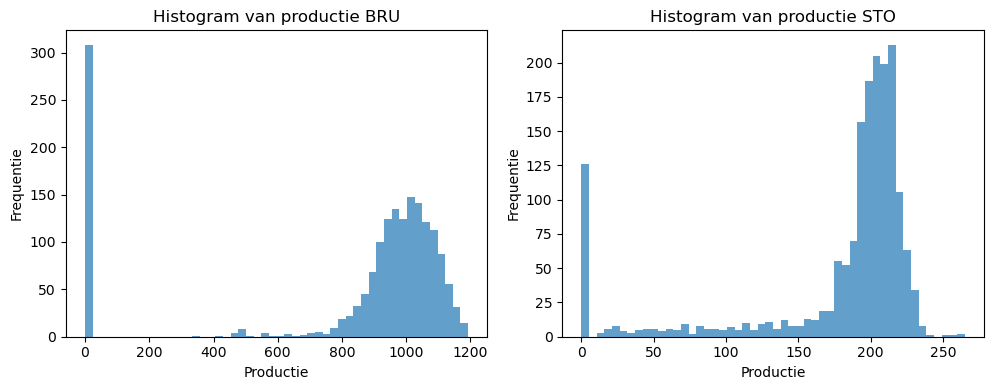

In [11]:
# Verkrijg de unieke locaties
unique_locations = combined_df_cleaned['location'].unique()

# Bereken het aantal rijen/kolommen benodigd voor de subplots
n_locs = len(unique_locations)
n_cols = 3  # Kies bijvoorbeeld 3 kolommen of een ander gewenst aantal
n_rows = n_locs // n_cols + (n_locs % n_cols > 0)

# Creëer een figuur en assen voor de subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)

for i, loc in enumerate(unique_locations):
    # Bereken de huidige rij en kolom
    row = i // n_cols
    col = i % n_cols
    
    # Filter de data voor de huidige locatie
    loc_data = combined_df_cleaned[combined_df_cleaned['location'] == loc]['production']
    
    # Plot histogram van productie voor de huidige locatie
    axs[row, col].hist(loc_data, bins=50, alpha=0.7)
    axs[row, col].set_title(f'Histogram van productie {loc}')
    axs[row, col].set_xlabel('Productie')
    axs[row, col].set_ylabel('Frequentie')

# Verberg overbodige subplots als het aantal locaties niet perfect in de grid past
for i in range(n_locs, n_rows * n_cols):
    fig.delaxes(axs.flatten()[i])

# Toon de plot
plt.tight_layout()
plt.show()

## Stap 5: Bepaal een geschikte verdeling voor het dagelijkse productieproces
Onderzoek en bepaal een geschikte kansverdeling die het beste past bij de kenmerken van het 
productieproces op een dag dat er normaalgesproken gewone productie zou moeten zijn op basis van d 
gegevens.

In bovenstaande grafieken is duidelijk zichtbaar dat een normaalverdeling niet zal volstaan om de data te fitten. Reden is de grote piek ter hoogte van 0, maar ook de lange linkerstaart samen met de korte rechterstaart. Om die reden besluiten we onze histogrammen (visueel) op te delen in 3 delen, en voor elk deel een geschikte fit te vinden. Dagen waarop we weten dat er geen productie is worden buiten beschouwing gelaten. Dagen waarop de productie onverwacht 0 is worden wel mee in rekening gebracht.

#### BRU
In het geval van BRU kozen we voor een **puntverdeling** op 0, een **uniforme verdeling** voor het tussengedeelte, en een **normaalverdeling** voor de 'normale' productie.

BRU: % dagen met [productie < 1e-08]: 17.74 %
BRU: % dagen met [1e-08 <= productie < 750]: 2.13 %
BRU: % dagen met [productie >= 750]: 80.13 %


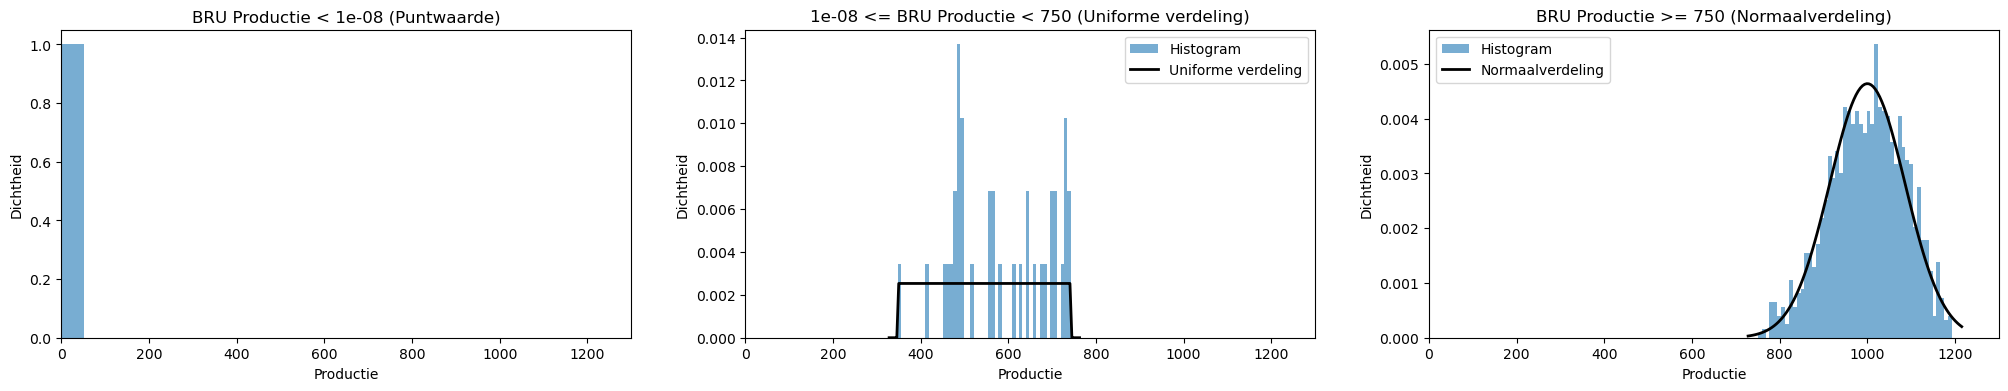

In [12]:
# Inputparameters BRU
location = 'BRU'
distribution_1 = generate_point_distribution
threshold_1 = 10**(-8)
distribution_2 = generate_uniform_distribution
threshold_2 = 750
distribution_3 = generate_normal_distribution

# Gebruik de functie 'create_segments' om de segmenten te maken (grenzen werden visueel bepaald)
# en het aandeel per segment te berekenen.
share_1, share_2, share_3, \
segment_1, segment_2, segment_3 = create_segments(location, threshold_1, threshold_2, combined_df_cleaned)

# Print aandeel per segment
print_segment_share(location, threshold_1, threshold_2, share_1, share_2, share_3)

# Genereer grafieken van de 3 segmenten
maximum = calculate_maximum(combined_df_cleaned, location)
plot_segment_distributions(segment_1, distribution_1,
                           segment_2, distribution_2, 
                           segment_3, distribution_3,                           
                           location, 
                           threshold_1, 
                           threshold_2, 
                           combined_df_cleaned,
                           maximum
                          )

#### STO
In het geval van STO kozen we voor een **puntverdeling** op 0, een **uniforme verdeling** voor het tussengedeelte, en een **cauchyverdeling** voor de 'normale' productie (heeft een scherpere piek dan de normaalverdeling).

STO: % dagen met [productie < 1e-08]: 7.34 %
STO: % dagen met [1e-08 <= productie < 150]: 9.62 %
STO: % dagen met [productie >= 150]: 83.04 %


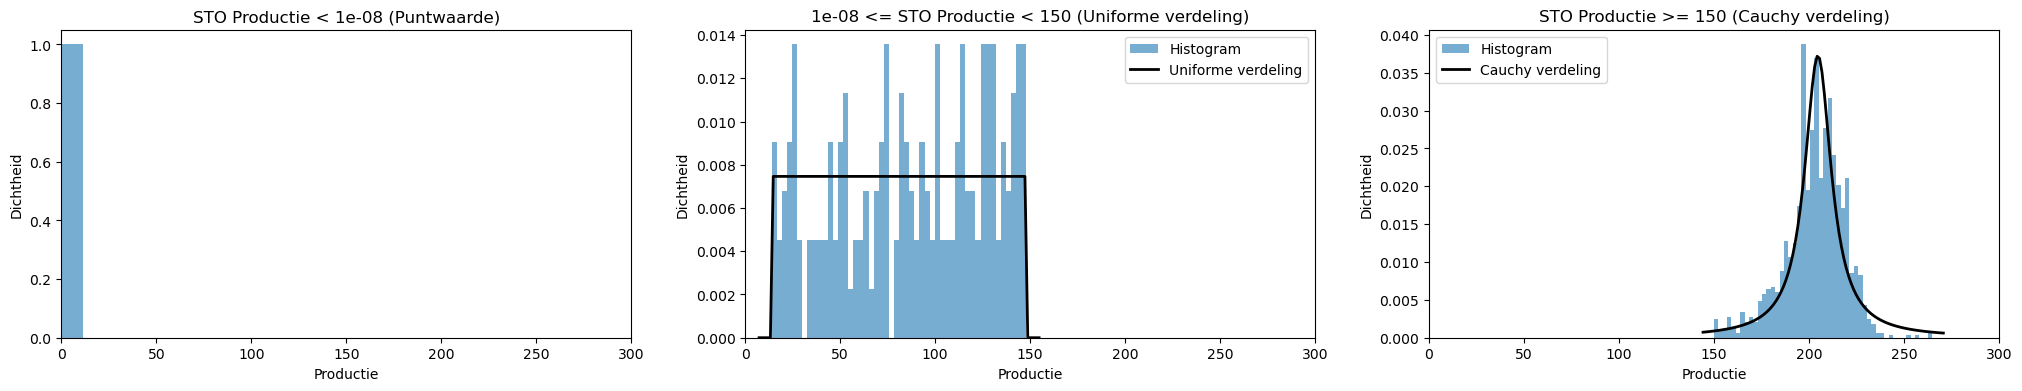

In [13]:
# Inputparameters STO
location = 'STO'
distribution_1 = generate_point_distribution
threshold_1 = 10**(-8)
distribution_2 = generate_uniform_distribution
threshold_2 = 150
distribution_3 = generate_cauchy_distribution

# Gebruik de functie 'create_segments' om de segmenten te maken (grenzen werden visueel bepaald)
# en het aandeel per segment te berekenen.
share_1, share_2, share_3, \
segment_1, segment_2, segment_3 = create_segments(location, threshold_1, threshold_2, combined_df_cleaned)

# Print aandeel per segment
print_segment_share(location, threshold_1, threshold_2, share_1, share_2, share_3)

# Genereer grafieken van de 3 segmenten
maximum = calculate_maximum(combined_df_cleaned, location)
plot_segment_distributions(segment_1, distribution_1,
                           segment_2, distribution_2, 
                           segment_3, distribution_3,                           
                           location, 
                           threshold_1, 
                           threshold_2, 
                           combined_df_cleaned,
                           maximum
                          )

## Stap 6: Simulatieprogramma ontwikkelen

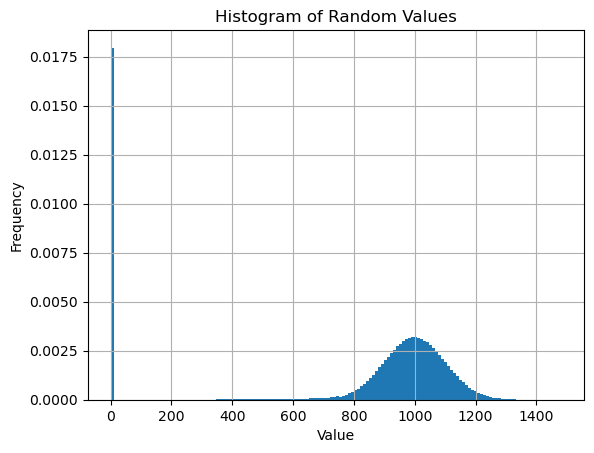

In [14]:
#------------RAF------------

# Simuleer 1 dag
# Example values for the input parameters
location = 'BRU'
threshold_1 = 10**(-8)
threshold_2 = 750
lower_bound = 350
upper_bound = 750
mean = 1000
stdev = 100

share_1, share_2, share_3, segment_1, segment_2, segment_3 = create_segments(location, threshold_1, threshold_2, combined_df_cleaned)


# Input
num_values = 10**6
n_days = 1

# Simuleer
simulated_data = simulate(share_1, share_2, lower_bound, upper_bound, mean, stdev, num_values, n_days)

# Plot
plt.hist(simulated_data, bins=round(num_values/10**4+50), density=True, alpha=1)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Random Values')
plt.grid(True)
plt.show()

17.74
2.13
80.13


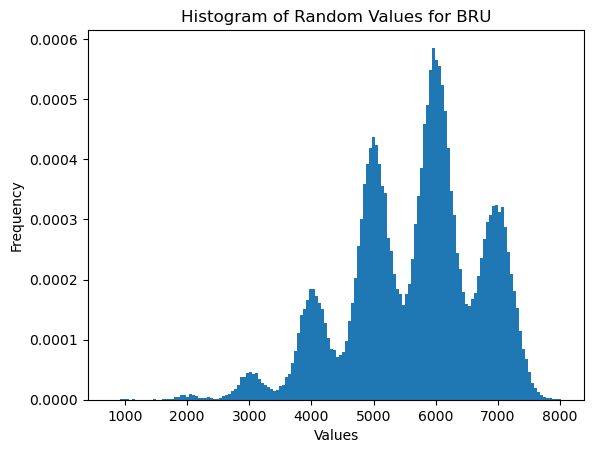

In [15]:

# Call generate_uniform_distribution to get the lower and upper bounds
#lower_bound, upper_bound = generate_uniform_distribution(segment_2, location, threshold_1, threshold_2, maximum)
# Print the lower and upper bounds
#print("Lower bound:", lower_bound)
#print("Upper bound:", upper_bound)




# -----------RAF----------
# Inputparameters BRU
location = 'BRU'
threshold_1 = 10**(-8)
threshold_2 = 750
lower_bound = 350
upper_bound = 750
mean = 1000
stdev = 100
# Gebruik de functie 'create_segments' om de segmenten te maken (grenzen werden visueel bepaald)
# en het aandeel per segment te berekenen.
share_1, share_2, share_3, \
segment_1, segment_2, segment_3 = create_segments(location, threshold_1, threshold_2, combined_df_cleaned)

print(share_1)
print(share_2)
print(share_3)

# ----------BRU---------

# Generate 100 random values
simulated_data = simulate(share_1, share_2, threshold_1, threshold_2, mean, stdev, num_values=10**5, n_days=7)

# Print the generated random values with two decimal places
#print(f"Random values for {location}:", [round(value, 2) for value in random_values])


# Plot a histogram of the random values
plt.hist(simulated_data, bins=round(num_values/10**4+50), density=True, alpha=1)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title(f'Histogram of Random Values for {location}')
plt.show()

Voer het aantal dagen in voor de simulatie:  7


Gesimuleerde productiewaarden:
Dag 1: 1234.4983202737662
Dag 2: 905.833492361281
Dag 3: 797.1385981347856
Dag 4: 946.0689137587385
Dag 5: 717.1127843960305
Dag 6: 0
Dag 7: 573.2139999387575


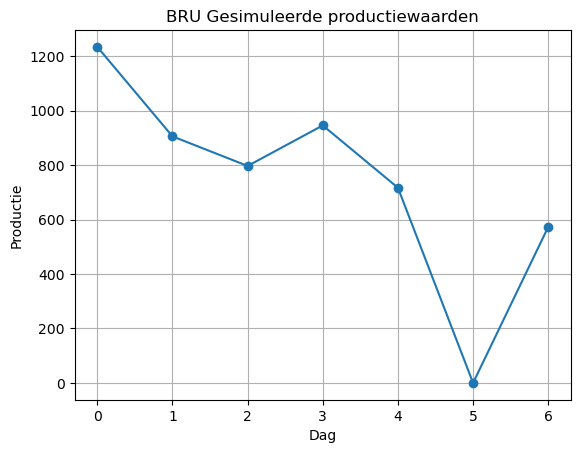

Gesimuleerde productiewaarden:
Dag 1: 99.11220120811099
Dag 2: 152.54273914030063
Dag 3: 175.21235557147907
Dag 4: 132.23376106801206
Dag 5: 250.82370173799305
Dag 6: 253.5833826645341
Dag 7: 154.02778176757562


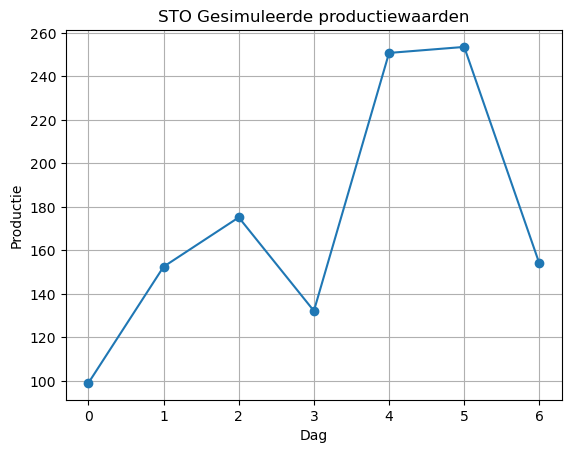

In [16]:
# -----------CARLO------------

# Vraag de gebruiker om de duur van de simulatie (n dagen)
n = int(input("Voer het aantal dagen in voor de simulatie: "))

# Verkrijg de unieke locaties
unique_locations = combined_df_cleaned['location'].unique()

for i, loc in enumerate(unique_locations):  
    # Filter de data voor de huidige locatie
    location = unique_locations[i]
    loc_data = combined_df_cleaned[combined_df_cleaned['location'] == location]['production']
    
    # Parameters voor de normaalverdeling (gemiddelde en standaarddeviatie)
    mean, std = stats.norm.fit(loc_data) #data_combined_df_cleaned)

    # Simuleer de productie
    simulated_data = simulate_production(n, mean, std)

    # Toon de gesimuleerde productiewaarden
    print("Gesimuleerde productiewaarden:")
    for i, value in enumerate(simulated_data, 1):
        print(f"Dag {i}: {value}")

    # Maak een chart
    chart_title = "Gesimuleerde productiewaarden"
    line_chart_daily_production(simulated_data, location, chart_title)


## 7 Gebruik je simulatie
Gebruik je simulatieprogramma om de productiekansen over een periode van n dagen te simuleren. Maak 
ook een grafiek van de empirische cd.f

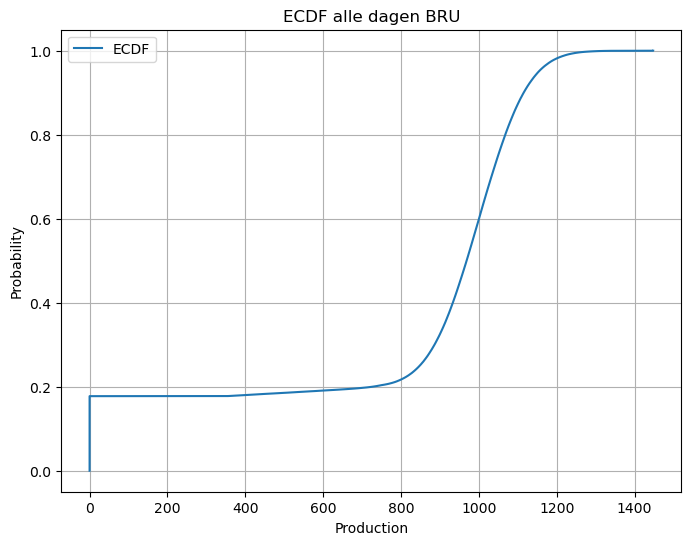

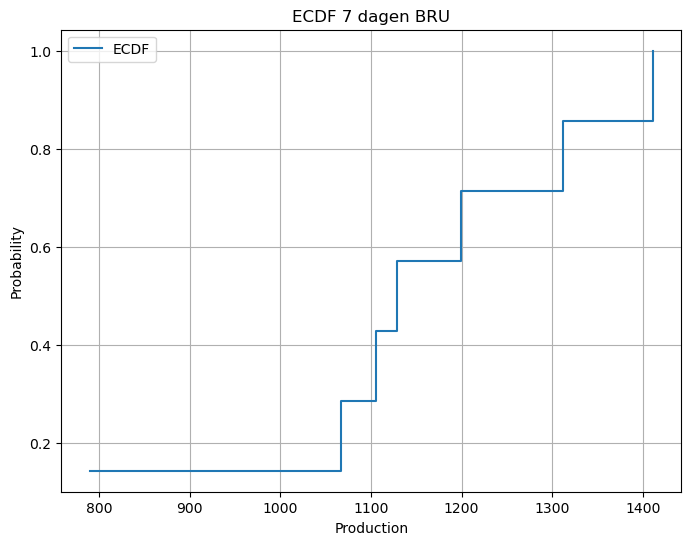

In [22]:
#---------------gekopieerde code uit opdracht 5 bovenaan----------------------
# Simuleer 1 dag
# Example values for the input parameters
location = 'BRU'
threshold_1 = 10**(-8)
threshold_2 = 750
lower_bound = 350
upper_bound = 750
mean = 1000
stdev = 100

share_1, share_2, share_3, segment_1, segment_2, segment_3 = create_segments(location, threshold_1, threshold_2, combined_df_cleaned)

# Input
num_values = 10**6
n_days = 1

# Simuleer
simulated_data = simulate(share_1, share_2, lower_bound, upper_bound, mean, stdev, num_values, n_days)
#---------------------einde gekopieerde code uit opdracht 5 bovenaan---------------


# ECDF: alle gesimuleerde dagen
n_days = 'alle'
def generate_ecdf(data):
    # Sorteer dataset
    sorted_data = np.sort(data)
    
    # Bereken y-as
    n = len(data)
    y_values = np.arange(1, n + 1) / n

    # Plot ECDF
    plt.figure(figsize=(8, 6))
    plt.step(sorted_data, y_values, where='post', label='ECDF')
    plt.xlabel('Production')
    plt.ylabel('Probability')
    plt.title(f'ECDF {n_days} dagen {location}')
    plt.legend()
    plt.grid(True)
    plt.show()
   
generate_ecdf(simulated_data)

# ECDF: gebruiker kiest aantal dagen
n_days = 7

def generate_ecdf_multiple_days(mean, std_dev, n_days):
    # Genereer productiedata via normale verdeling
    production_data = np.random.normal(loc=mean, scale=std_dev, size=n_days)

    # Maak ECDF plot van productie-data
    generate_ecdf(production_data)

# Parameters voor normale verdeling
mean = sum(simulated_data)/len(simulated_data)
stdev = np.std(np.array(simulated_data))

# Maak ECDF plot
generate_ecdf_multiple_days(mean, stdev, n_days)

## Bonus: Vergelijken met de centrale limietstelling

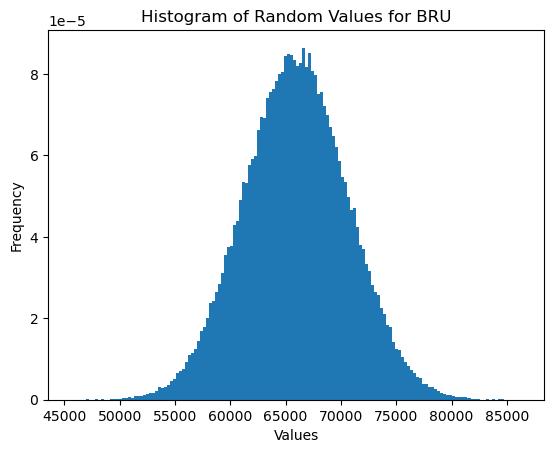

In [18]:
simulated_data_n_100 = simulate(share_1, share_2, threshold_1, threshold_2, mean, stdev, num_values=10**5, n_days=10**2)

plt.hist(simulated_data_n_100, bins=round(num_values/10**4+50), density=True, alpha=1)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title(f'Histogram of Random Values for {location}')
plt.show()